In [1]:
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
from prophet import Prophet
from tqdm import tqdm

from forecast import train_and_forecast

In [2]:
START_DATE = "2020-01-02"
END_DATE = "2022-01-01"
ticker_list = ["FB", "GOOG", "ORCL", "MSFT", "AMZN"]

In [3]:
data = yf.download(ticker_list, start=START_DATE, end=END_DATE)[["Close"]]

[*********************100%***********************]  5 of 5 completed


In [4]:
data.columns = data.columns.droplevel()
data.head()

,AMZN,FB,GOOG,MSFT,ORCL
Date,,,,,
2020-01-02,94.900497,209.779999,68.368500,160.619995,53.950001
2020-01-03,93.748497,208.669998,68.032997,158.619995,53.759998
2020-01-06,95.143997,212.600006,69.710503,159.029999,54.040001
2020-01-07,95.343002,213.059998,69.667000,157.580002,54.160000
2020-01-08,94.598503,215.220001,70.216003,160.089996,54.130001


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    505 non-null    float64
 1   FB      505 non-null    float64
 2   GOOG    505 non-null    float64
 3   MSFT    505 non-null    float64
 4   ORCL    505 non-null    float64
dtypes: float64(5)
memory usage: 23.7 KB


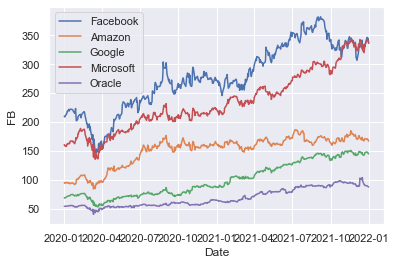

In [6]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.lineplot(x=data.index, y=data["FB"])
sns.lineplot(x=data.index, y=data["AMZN"])
sns.lineplot(x=data.index, y=data["GOOG"])
sns.lineplot(x=data.index, y=data["MSFT"])
sns.lineplot(x=data.index, y=data["ORCL"])
plt.legend(labels=["Facebook", "Amazon", "Google", "Microsoft", "Oracle"])

In [7]:
data = data.reset_index()
df = pd.melt(data, id_vars="Date", value_vars=["AMZN", "FB", "GOOG", "MSFT", "ORCL"])
df.columns = ["ds", "ticker", "y"]
df.head()

,ds,ticker,y
0,2020-01-02,AMZN,94.900497
1,2020-01-03,AMZN,93.748497
2,2020-01-06,AMZN,95.143997
3,2020-01-07,AMZN,95.343002
4,2020-01-08,AMZN,94.598503


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2525 non-null   datetime64[ns]
 1   ticker  2525 non-null   object        
 2   y       2525 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.3+ KB


In [9]:
groups_by_ticker = df.groupby("ticker")
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'FB', 'GOOG', 'MSFT', 'ORCL'])

In [10]:
groups_by_ticker.head()

,ds,ticker,y
0,2020-01-02,AMZN,94.900497
1,2020-01-03,AMZN,93.748497
2,2020-01-06,AMZN,95.143997
3,2020-01-07,AMZN,95.343002
4,2020-01-08,AMZN,94.598503
505,2020-01-02,FB,209.779999
506,2020-01-03,FB,208.669998
507,2020-01-06,FB,212.600006
508,2020-01-07,FB,213.059998
509,2020-01-08,FB,215.220001


In [ ]:
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]
p = Pool(cpu_count())
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))
p.close()
p.join()
multiprocess_forecast = pd.concat(predictions)